#### they said there are two subgraphs types
1. when same shared state
( For example, in multi-agent systems, the agents often communicate over a shared messages key.)
2. when diff and call the sub in one of parent node

 A common application of subgraphs is to build multi-agent systems.

#1

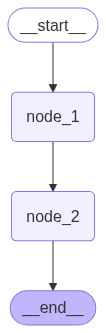

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START

# Define subgraph
class SubgraphState(TypedDict):
    foo: str  
    bar: str  

def subgraph_node_1(state: SubgraphState):
    return {"bar": "bar"}

def subgraph_node_2(state: SubgraphState):
    # note that this node is using a state key ('bar') that is only available in the subgraph
    # and is sending update on the shared state key ('foo')
    return {"foo": state["foo"] + state["bar"]}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()

# Define parent graph
class ParentState(TypedDict):
    foo: str

def node_1(state: ParentState):
    return {"foo": "hi! " + state["foo"]}

builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", subgraph)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.compile()


In [ ]:
graph = builder.compile()
for chunk in graph.stream({"foo": "foo"}):
    print(chunk)

# Different state schema
For more complex systems you might want to define subgraphs that have a completely different schema from the parent graph (no shared keys).
For example, you might want to keep a private message history for each of the agents in a multi-agent system.

😂 everything in docs

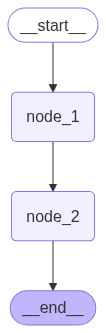

In [2]:
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START

# Define subgraph
class SubgraphState(TypedDict):
    # note that none of these keys are shared with the parent graph state
    bar: str
    baz: str

def subgraph_node_1(state: SubgraphState):
    return {"baz": "baz"}

def subgraph_node_2(state: SubgraphState):
    return {"bar": state["bar"] + state["baz"]}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()

# Define parent graph
class ParentState(TypedDict):
    foo: str

def node_1(state: ParentState):
    return {"foo": "hi! " + state["foo"]}

def node_2(state: ParentState):
    response = subgraph.invoke({"bar": state["foo"]})  
    return {"foo": response["bar"]}  


builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.compile()

In [3]:
graph = builder.compile()

for chunk in graph.stream({"foo": "foo"}, subgraphs=True):
    print(chunk)

((), {'node_1': {'foo': 'hi! foo'}})
(('node_2:406322a2-4cf5-d8b5-6595-0b2b348830ac',), {'subgraph_node_1': {'baz': 'baz'}})
(('node_2:406322a2-4cf5-d8b5-6595-0b2b348830ac',), {'subgraph_node_2': {'bar': 'hi! foobaz'}})
((), {'node_2': {'foo': 'hi! foobaz'}})


1. Full example: different state schemas (two levels of subgraphs)
1. This is an example with two levels of subgraphs: parent -> child -> grandchild.

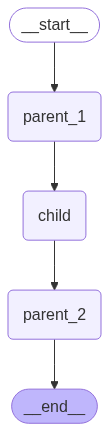

In [ ]:
# Grandchild graph
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START, END

class GrandChildState(TypedDict):
    my_grandchild_key: str

def grandchild_1(state: GrandChildState) -> GrandChildState:
    # NOTE: child or parent keys will not be accessible here
    return {"my_grandchild_key": state["my_grandchild_key"] + ", how are you"}


grandchild = StateGraph(GrandChildState)
grandchild.add_node("grandchild_1", grandchild_1)

grandchild.add_edge(START, "grandchild_1")
grandchild.add_edge("grandchild_1", END)

grandchild_graph = grandchild.compile()

# Child graph
class ChildState(TypedDict):
    my_child_key: str

def call_grandchild_graph(state: ChildState) -> ChildState:
    # NOTEe: parent or grandchild keys won't be accessible here
    grandchild_graph_input = {"my_grandchild_key": state["my_child_key"]}  
    grandchild_graph_output = grandchild_graph.invoke(grandchild_graph_input)
    return {"my_child_key": grandchild_graph_output["my_grandchild_key"] + " today?"}  

child = StateGraph(ChildState)
child.add_node("child_1", call_grandchild_graph)  
child.add_edge(START, "child_1")
child.add_edge("child_1", END)
child_graph = child.compile()

# Parent graph
class ParentState(TypedDict):
    my_key: str

def parent_1(state: ParentState) -> ParentState:
    # NOTE: child or grandchild keys won't be accessible here
    return {"my_key": "hi " + state["my_key"]}

def parent_2(state: ParentState) -> ParentState:
    return {"my_key": state["my_key"] + " bye!"}

def call_child_graph(state: ParentState) -> ParentState:
    child_graph_input = {"my_child_key": state["my_key"]}  
    child_graph_output = child_graph.invoke(child_graph_input)
    return {"my_key": child_graph_output["my_child_key"]}  

parent = StateGraph(ParentState)
parent.add_node("parent_1", parent_1)
parent.add_node("child", call_child_graph)  
parent.add_node("parent_2", parent_2)

parent.add_edge(START, "parent_1")
parent.add_edge("parent_1", "child")
parent.add_edge("child", "parent_2")
parent.add_edge("parent_2", END)
parent.compile()

In [6]:

parent_graph = parent.compile()

for chunk in parent_graph.stream({"my_key": "Bob"}, subgraphs=True):
    print(chunk)

((), {'parent_1': {'my_key': 'hi Bob'}})
(('child:0fa89b04-0f48-ac8c-f334-f7976da88a66', 'child_1:35b29f9b-3ca1-eeee-edad-befaad60571e'), {'grandchild_1': {'my_grandchild_key': 'hi Bob, how are you'}})
(('child:0fa89b04-0f48-ac8c-f334-f7976da88a66',), {'child_1': {'my_child_key': 'hi Bob, how are you today?'}})
((), {'child': {'my_key': 'hi Bob, how are you today?'}})
((), {'parent_2': {'my_key': 'hi Bob, how are you today? bye!'}})
